# Hilbert space methods for reduced-rank Gaussian Process Regression (2019)

Arno Solin - Simo Särkkä 

https://arxiv.org/abs/1401.5508

_Note:equation numbers correspond to the equation numbers in the source paper._

### The aproximation of the kernel is given by

$$k(x, x') \approx \sum_{j} S(\sqrt{\lambda_j})\phi_j(x) \phi(x')$$

Where $S(\cdot)$ is the PSD of the GP given by the Fourier transform of the kernel, $\lambda_j, \phi_j$ are the eigen values and functions of the laplace operator.


Where $\phi, \lambda$ comes from the dirichelt eigenvalue equation, given a $\Omega \subset \mathbb{R}^d$ a compact set, 

(Eq 10)
$$\begin{cases} 
-\nabla^2 \phi_j(x) & = \lambda_j \phi_j(x), \quad x \in \Omega\\
\phi_j(x) & = 0, \quad x \in \delta \Omega
\end{cases}$$


Then, defining $\Omega = [-L, L], \, L \in \mathbb{R}$, yields the eigenvalues and functions,

(Eq 56)

$$\phi_j(x)= L^{-1/2} \sin\left(\frac{\pi j (x + L)}{2L}\right)$$

$$\lambda_j = \left(\frac{\pi j}{2L}\right)^2$$


With this we can approximate the kernel and do inference in the approximated model

## GP approximation

(Eq 37)
\begin{align}
\mathbb{E}[f_*] & \approx \phi_*^{\top}\left(\Phi^{\top} \Phi + \sigma_n^2\Lambda^{-1} \right)^{-1} \Phi^{\top} y\\
\mathbb{V}[f_*] & \approx \sigma_n^2 \phi_*^{\top}\left(\Phi^{\top} \Phi + \sigma_n^2\Lambda^{-1} \right)^{-1}\phi_*
\end{align}

with $\phi_* = [\phi_1(x_*), \ldots, \phi_m(x_*)]$

# Notes:

* Fast method for training
* Specially sensible to boundary $L$ and number of components $m$
    - A high $m$ with a not adecuate $L$ makes the eigen values go to zero, creating overflow in division.
* Dificult to set parameters $m$ and $L$ for kernels with non-zero-centered PSD .


### Parameter heuristics

* The number of eigenfunctions $M$ should the higher the more sharper the kernel is, that is the more smoth is the kernel fewer the needed components.

* Boundary $L$ is roughly the same range as the input range.

In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import hilbert_gp as hgp

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
plt.rcParams['figure.figsize'] = (12, 5)
sns.set_context('notebook', font_scale=1.4)
sns.set_style('ticks')

####  Kernels
Here we define the kernels, assuming $\tau = x - x'$

> __Squared exponential__ Kernel defined by
$$ k_{se}(\tau)= \sigma^2 \exp(-\gamma \tau^2)$$
With power spectral density given by
$$ S_{se}(\xi) = \sigma^2 \sqrt{\frac{\pi}{\gamma}} \exp(-\frac{\xi^2}{4 \gamma})$$

> __Spectral mixture__ kernel defined by
$$ k_{sm}(\tau) = \sum_{q=1}^{Q} w_q \exp\left(-\frac{1}{2}\gamma_q \tau^2\right) \cos(\mu_q^{\top} \tau)$$
and psd
$$ S_{sm}(\xi) = \sum_{q=1}^{Q}w_q \frac{1}{ \sqrt{2\pi \gamma}} \exp\left( -\frac{(\tau - \mu_q)^2}{2\gamma_q}  \right)$$

## Squared exponential kernel

#### kernel approximation

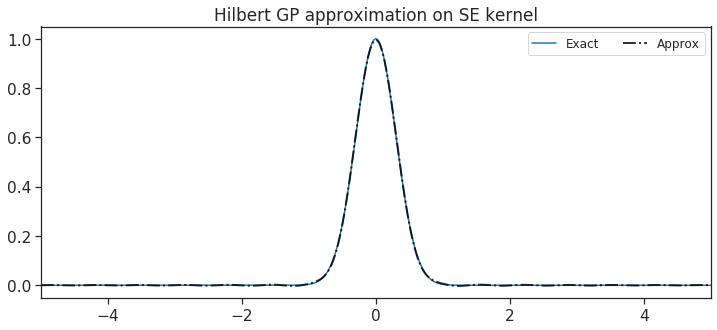

In [3]:
# kernel parameters
l = 0.3 # lenghtscale
gamma = 1 / (2* l**2)
sigma = 1 # scale

m = 300 # number of basis functions
L = 50 # bounding box

kern_params = {'gamma':gamma, 'sigma':sigma}

# inputs
t, dt = np.linspace(-5, 5, 1000, retstep=True)

# create model
model_se = hgp.HilbertGP(kernel='SE', L=L, m=m, kern_params=kern_params)

# compute kernels
exact_kernel = hgp.se_kernel(t, [0], **kern_params)
approx_kernel = model_se.kernel_approx(t, np.zeros(1))

# plot
plt.plot(t, exact_kernel, lw=1.5, label='Exact')
plt.plot(t, approx_kernel, '-.k', lw=2, label='Approx', alpha=0.8)
plt.xlim(t[0], t[-1])
plt.legend(fontsize=12, ncol=2)
plt.title('Hilbert GP approximation on SE kernel');

# Spectral mixture kernel

Spectral mixture kernel with 2 components

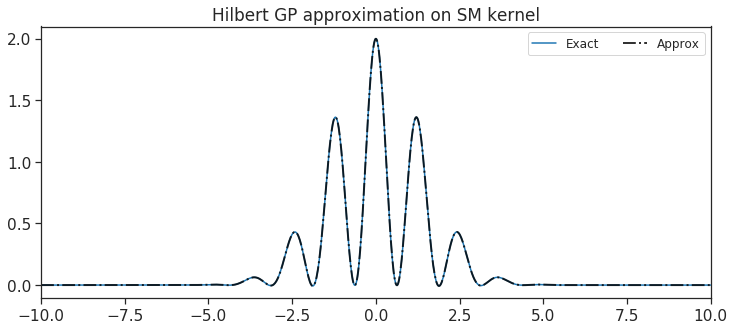

In [4]:
l = np.array([1, 1])
w = np.array([1, 1])
mu = np.array([5, 0.1])
gamma = 1 / (2 * l**2)
sigma_noise = 0.4

m = 80
L = 10

kern_params = {'gamma':gamma, 'mu':mu, 'w':w}
model_sm = hgp.HilbertGP(kernel='SM', L=L, m=m, kern_params=kern_params, sigma_noise=sigma_noise)

t, dt = np.linspace(-10, 10, 1000, retstep=True)

# compute kernels
exact_kernel = hgp.sm_kernel(t, [0], **kern_params)
approx_kernel = model_sm.kernel_approx(t, np.zeros(1))

# plot
plt.plot(t, exact_kernel, lw=1.5, label='Exact')
plt.plot(t, approx_kernel, '-.k', lw=2, label='Approx', alpha=0.8)
plt.xlim(t[0], t[-1])
plt.legend(ncol=2, fontsize=12)
plt.title('Hilbert GP approximation on SM kernel');

#### Toy example

Generate function as a sum of sinusoidals, then sample and perform inference with Hilbert-GP.

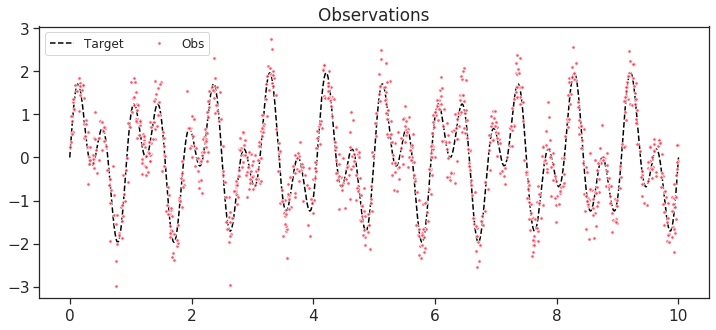

In [5]:
np.random.seed(123)
sigma_n = 0.4

t = np.linspace(0, 10, 5000)

f = lambda t: (1 * np.sin(2 * np.pi * 1 * t) + 1 * np.sin(2 * np.pi * 2.2 * t))

i_obs = np.random.choice(np.arange(len(t)), replace=False, size=1000)

t_obs = t[i_obs]
y_obs = f(t)[i_obs] + np.random.normal(scale=sigma_n, size=len(t_obs))

plt.plot(t, f(t), '--k', label='Target')
plt.plot(t_obs, y_obs, '.', ms=7, alpha=0.8, mec='w', c='xkcd:strawberry', label='Obs')
plt.legend(ncol=2, fontsize=12)
plt.title('Observations');

### Make predictions with untrained model

In [6]:
# HilbertGP approx parameters
m = 250
L = 20

Q = 2
# mixture weights
# w = np.array([.5, .5])
w = np.random.random(2)

# mixture scales
# gamma = np.array([.01, .1]) 
gamma = np.random.random(2)

# mixture means
mu = np.array([5, 10])


sigma_noise = 1

kern_params = {'w':w, 'gamma':gamma, 'mu':mu}
# create model
model_sm = hgp.HilbertGP(
    t_obs,
    y_obs,
    kernel='SM',
    L=L,
    m=m,
    Q=Q,
    kern_params=kern_params,
    sigma_noise=sigma_noise)
model_sm.set_kernel_parameters(kern_params)

theta = np.r_[w, gamma, mu, sigma_n]

t_star = np.linspace(0, 15, 1000)

mu_post, cov_post = model_sm.posterior(t_star)

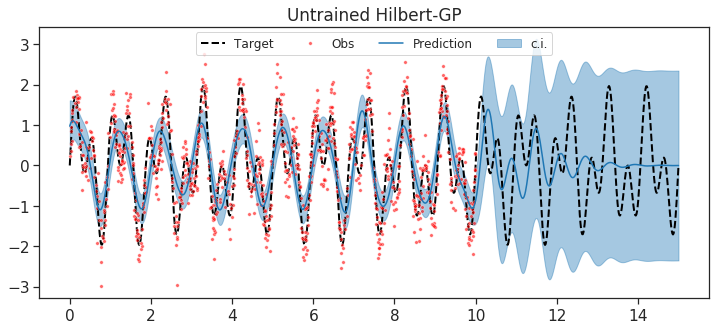

In [7]:
plt.plot(t_star, f(t_star), '--k', label='Target', lw=2)
plt.plot(t_obs, y_obs, '.r', label='Obs', ms=7, alpha=0.6, mec='w', mew=0.5)
plt.plot(t_star, mu_post, c=sns.color_palette()[0], label='Prediction')
plt.fill_between(t_star,
                 mu_post + 2 * np.sqrt(cov_post),
                 mu_post - 2 * np.sqrt(cov_post),
                 color=sns.color_palette()[0],
                 alpha=0.4,
                 label='c.i.');
plt.legend(loc='upper center', ncol=4, fontsize=12)
plt.title('Untrained Hilbert-GP');

#### Training the model

In [8]:
model_sm.fit(niter=500, tol=1e-30);

Initial NLL: 837.2936145826649
Trained NLL: 61.64360409775196
Model trained in 16.71776843070984 secs


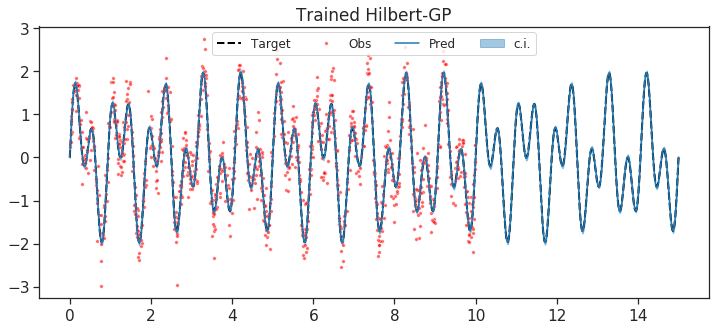

In [9]:
mu_post, cov_post = model_sm.posterior(t_star)

plt.plot(t_star, f(t_star), '--k', label='Target', lw=2)
plt.plot(t_obs, y_obs, '.r', label='Obs', ms=7, alpha=0.6, mec='w', mew=0.5)
plt.plot(t_star, mu_post, c=sns.color_palette()[0], label='Pred')
plt.fill_between(t_star,
                 mu_post + 2 * np.sqrt(cov_post),
                 mu_post - 2 * np.sqrt(cov_post),
                 color=sns.color_palette()[0],
                 alpha=0.4,
                 label='c.i.');
plt.legend(loc='upper center', ncol=4, fontsize=12)
plt.title('Trained Hilbert-GP');